# Bayesian Logistic Regression

In [320]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from scipy.stats import logistic

import pymc3 as pm
import arviz as az

az.style.use('arviz-darkgrid')

## Diabetes dataset
Let us analyze Pima Indians Diabetes Database: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database.

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least $21$ years old of Pima Indian heritage.

In [4]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.shape

(768, 9)

This dataset contains $768$ observations, $268$ of $768$ are diabetic.

Target variable:
- `Outcome`: $0$ if non-diabetic, $1$ if diabetic.

Predictors:
- `Pregnancies`: Number of times pregnant;
- `Glucose`: Plasma glucose concentration a $2$ hours in an oral glucose tolerance test;
- `BloodPressure`: Diastolic blood pressure (mm Hg);
- `SkinThickness`: Triceps skin fold thickness (mm);
- `Insulin`: $2$-Hour serum insulin (mu U/ml);
- `BMI`: Body mass index (weight in kg/(height in m)^2);
- `DiabetesPedigreeFunction`: A function which scores likelihood of diabetes based on family history;
- `Age`: Age (years).

In [339]:
df.drop('Outcome', axis = 1).describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


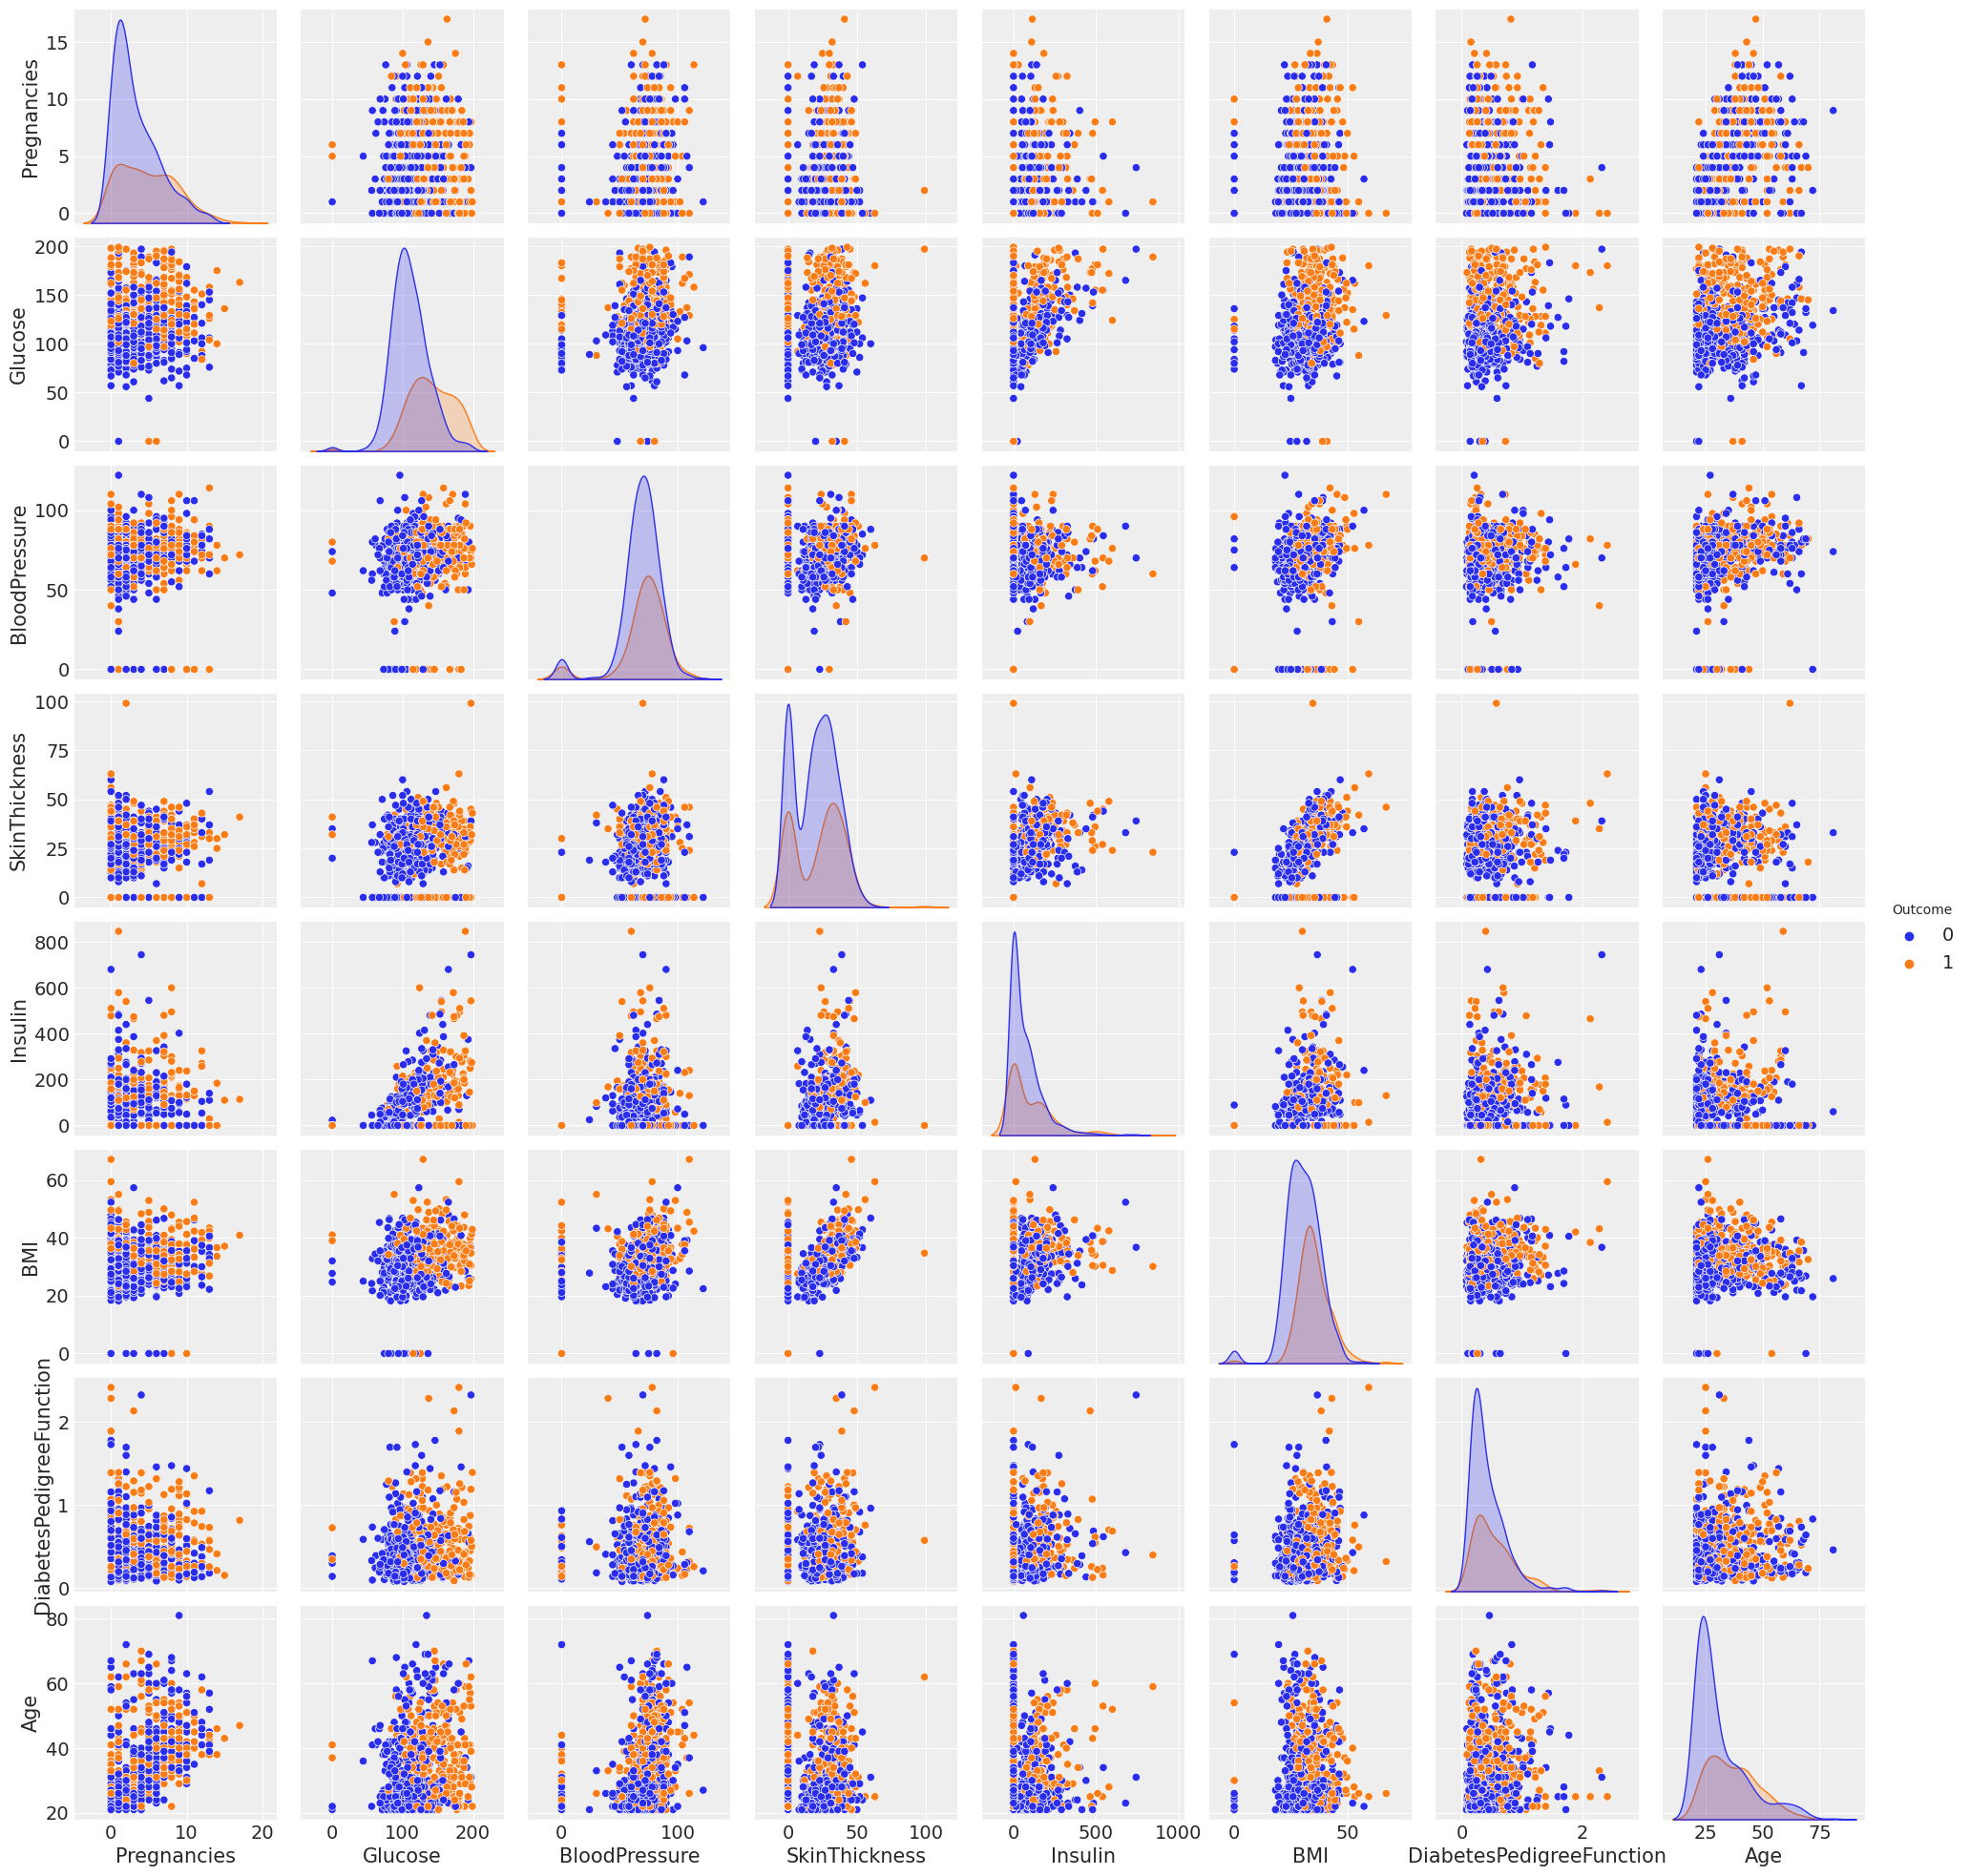

In [322]:
sns.pairplot(df, hue = 'Outcome', diag_kind = 'kde')
plt.show()

In [33]:
t = df.iloc[:,-1]
reg = df.iloc[:,:-1]

In [326]:
# normalize data
means = np.array(reg.mean(axis=0))
print('Means =', means)
scales = np.array(reg.std(axis=0))
print('Scales =', scales)
reg_norm = (reg - means)/scales
reg_norm

Means = [  3.84505208 120.89453125  69.10546875  20.53645833  79.79947917
  31.99257812   0.4718763   33.24088542]
Scales = [  3.36957806  31.9726182   19.35580717  15.95221757 115.24400235
   7.88416032   0.3313286   11.76023154]


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639530,0.847771,0.149543,0.906679,-0.692439,0.203880,0.468187,1.425067
1,-0.844335,-1.122665,-0.160441,0.530556,-0.692439,-0.683976,-0.364823,-0.190548
2,1.233077,1.942458,-0.263769,-1.287373,-0.692439,-1.102537,0.604004,-0.105515
3,-0.844335,-0.997558,-0.160441,0.154433,0.123221,-0.493721,-0.920163,-1.040871
4,-1.141108,0.503727,-1.503707,0.906679,0.765337,1.408828,5.481337,-0.020483
...,...,...,...,...,...,...,...,...
763,1.826623,-0.622237,0.356200,1.721613,0.869464,0.115094,-0.908090,2.530487
764,-0.547562,0.034575,0.046215,0.405181,-0.692439,0.609757,-0.398023,-0.530677
765,0.342757,0.003299,0.149543,0.154433,0.279412,-0.734711,-0.684747,-0.275580
766,-0.844335,0.159683,-0.470426,-1.287373,-0.692439,-0.240048,-0.370859,1.169970


In [40]:
# append ones
X = np.hstack([np.ones(shape=(reg_norm.shape[0], 1)), reg_norm])
X.shape

(768, 9)

## MCMC approach
Bayesian Logistic Regression model:
$$
t_i | x_i, \mathbf w \sim \mathrm{Be}(\theta(\mathbf x_i))
\\
\theta(x) = \mathrm{logit}(\mathbf w^T \mathbf x)
\\
\mathbf w_j \sim  \mathcal N(0, S_j^2)
\\
S_0 = 10;\ S_k = 2, \ k = \overline{1,8}
$$

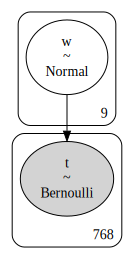

In [45]:
w0_sd = 10 # sd for w0
w_sd = 2 # sd for predictors
with pm.Model() as model:
    w = pm.Normal('w', mu=0, sd=np.concatenate([[w0_sd], np.repeat(w_sd, X.shape[1] - 1)]), shape=X.shape[1])
    theta = pm.invlogit(pm.math.dot(w, X.T))
    outputs = pm.Bernoulli('t', theta, observed=t)
    
pm.model_to_graphviz(model)

In [46]:
with model:
    trace = pm.sample(draws=2000, tune=1000, chains=4, cores=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Serg\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\Serg\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3685 seconds.


Now we have $4$ chains $2000$ length for every $\mathbf w_j,\ j=\overline{0,8}$. 

In [47]:
trace.posterior['w'].shape

(4, 2000, 9)

Let's analyze whether chains converged to a stationary distribution or not.

The graphs below shows that the chains are indistinguishable. That is a good sign!

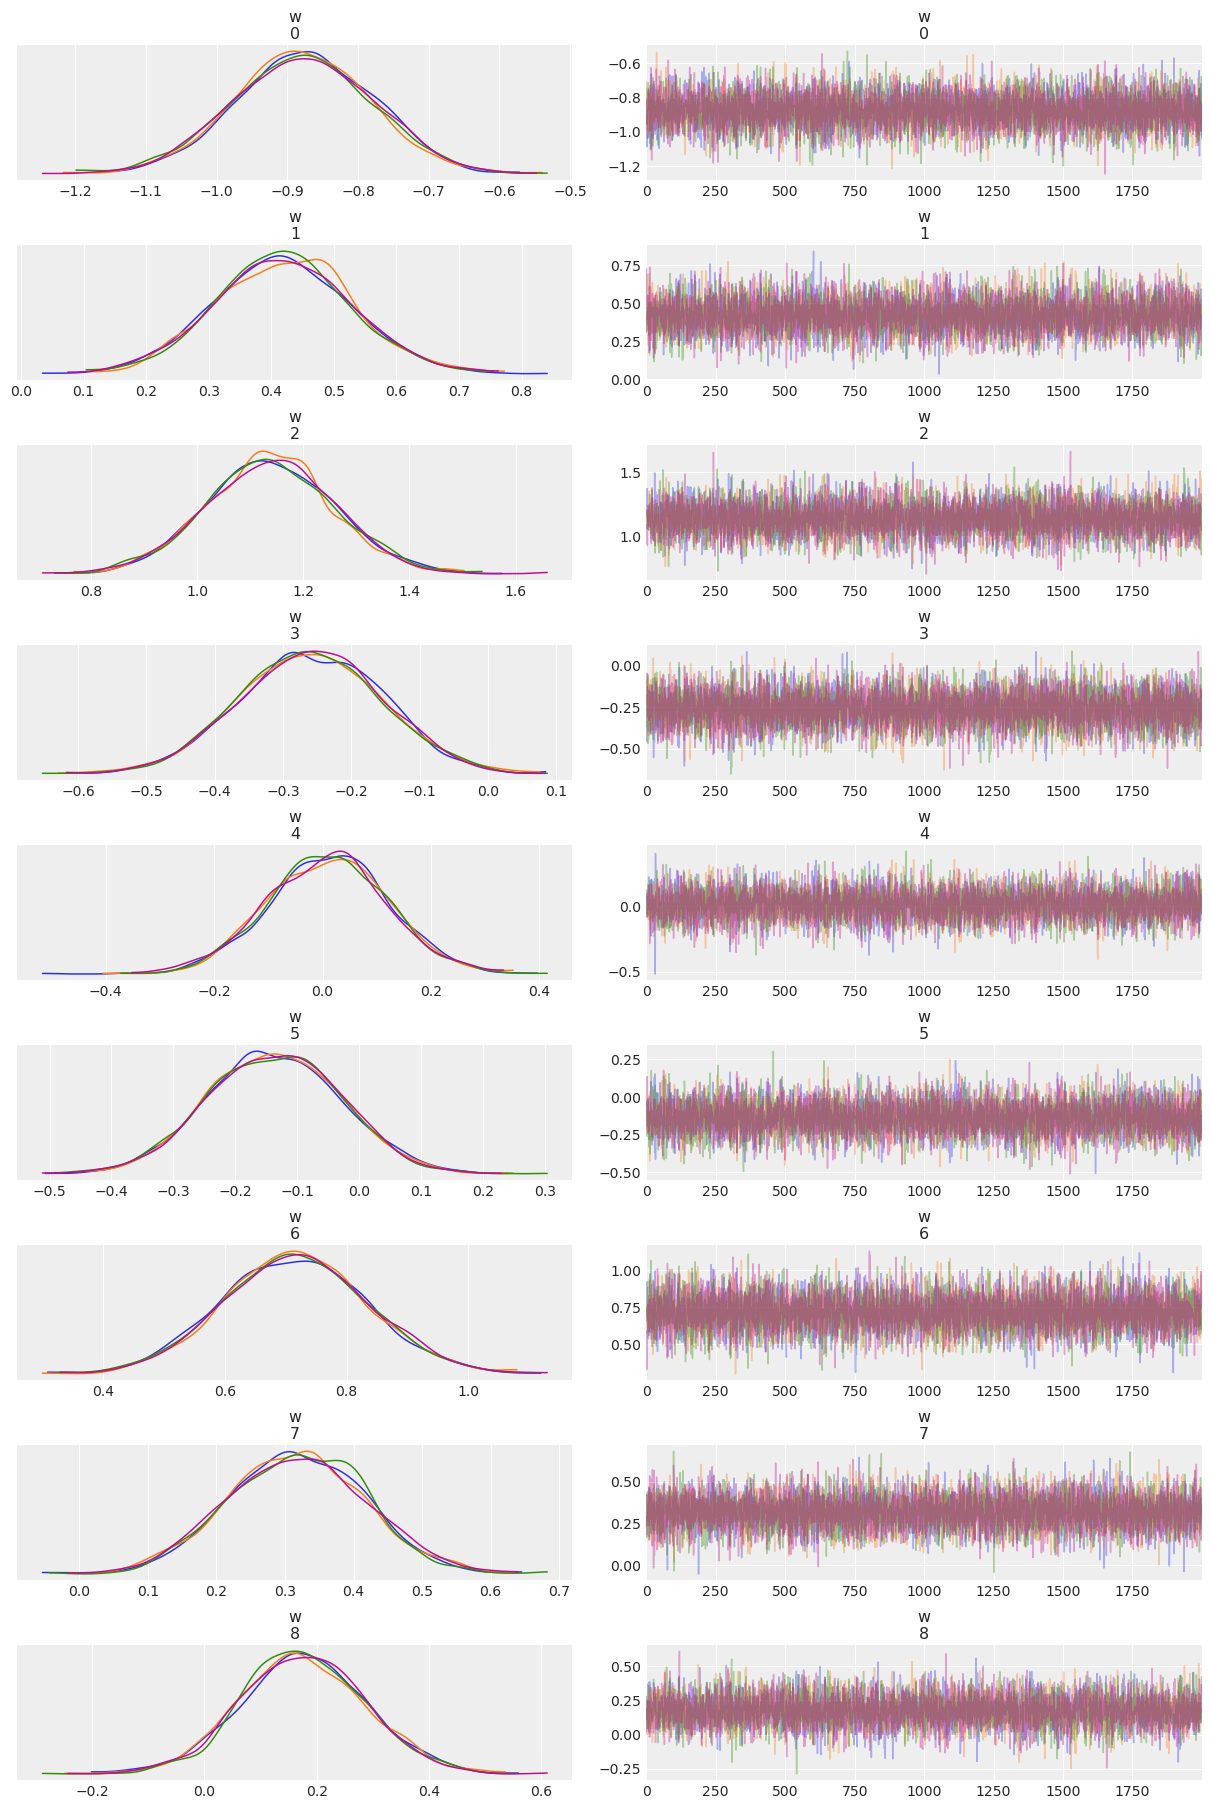

In [53]:
az.plot_trace(trace, compact=False)
plt.show()

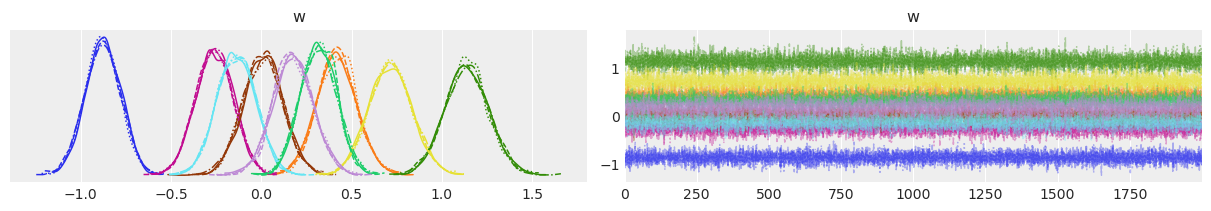

In [54]:
az.plot_trace(trace, compact=True)
plt.show()

There is no problems with autocorrelations.

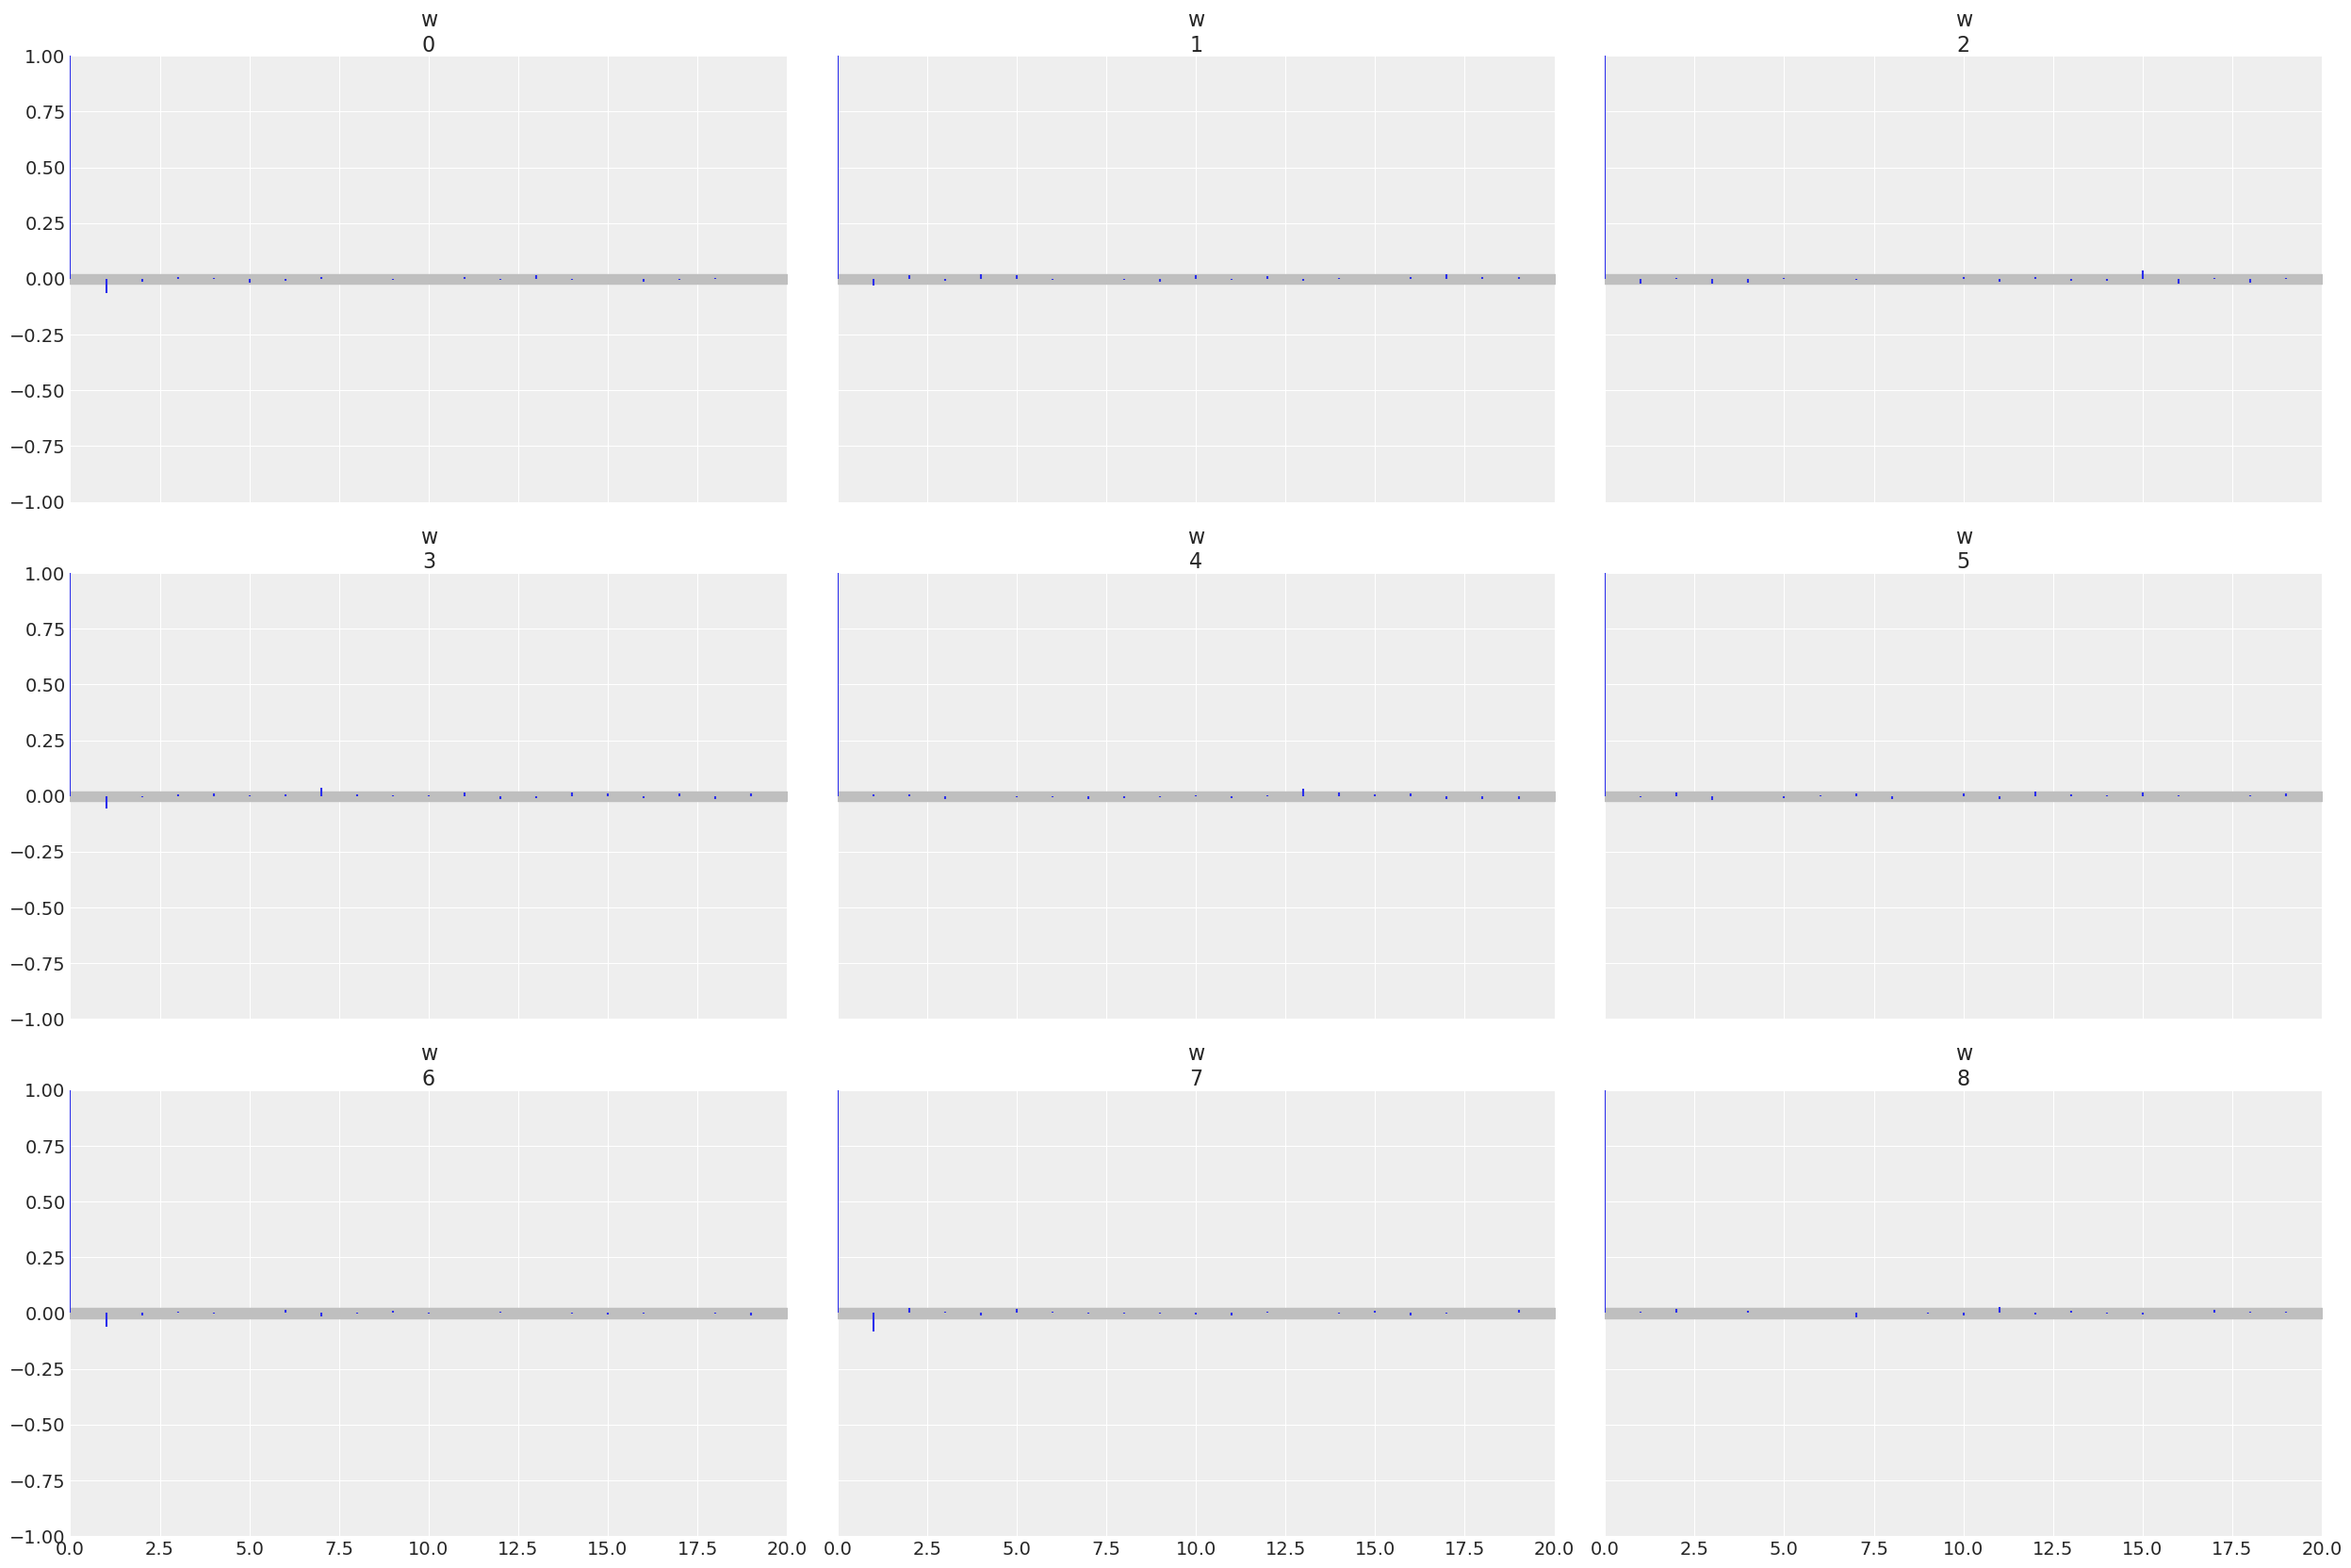

In [56]:
az.plot_autocorr(trace, max_lag=20, combined=True)
plt.show()

All $\hat{R}_j,\ j=\overline{0,8}$ are very close to $1$, effective sample sizes are also pretty good.

In [67]:
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],-0.88,0.10,-1.06,-0.69,0.0,0.0,9220.61,6806.55,1.0
w[1],0.42,0.11,0.22,0.63,0.0,0.0,8339.99,6524.72,1.0
w[2],1.14,0.12,0.91,1.37,0.0,0.0,8397.11,6196.99,1.0
w[3],-0.26,0.10,-0.45,-0.06,0.0,0.0,9030.98,6408.90,1.0
w[4],0.01,0.11,-0.20,0.21,0.0,0.0,7866.29,6156.93,1.0
w[5],-0.14,0.11,-0.34,0.06,0.0,0.0,8013.59,6109.25,1.0
w[6],0.72,0.12,0.49,0.93,0.0,0.0,9188.45,7008.56,1.0
w[7],0.32,0.10,0.13,0.50,0.0,0.0,8919.14,6372.33,1.0
w[8],0.18,0.11,-0.03,0.39,0.0,0.0,7468.65,6038.96,1.0


Let's take a look at the posterior $\mathbf w_j$ distributions.

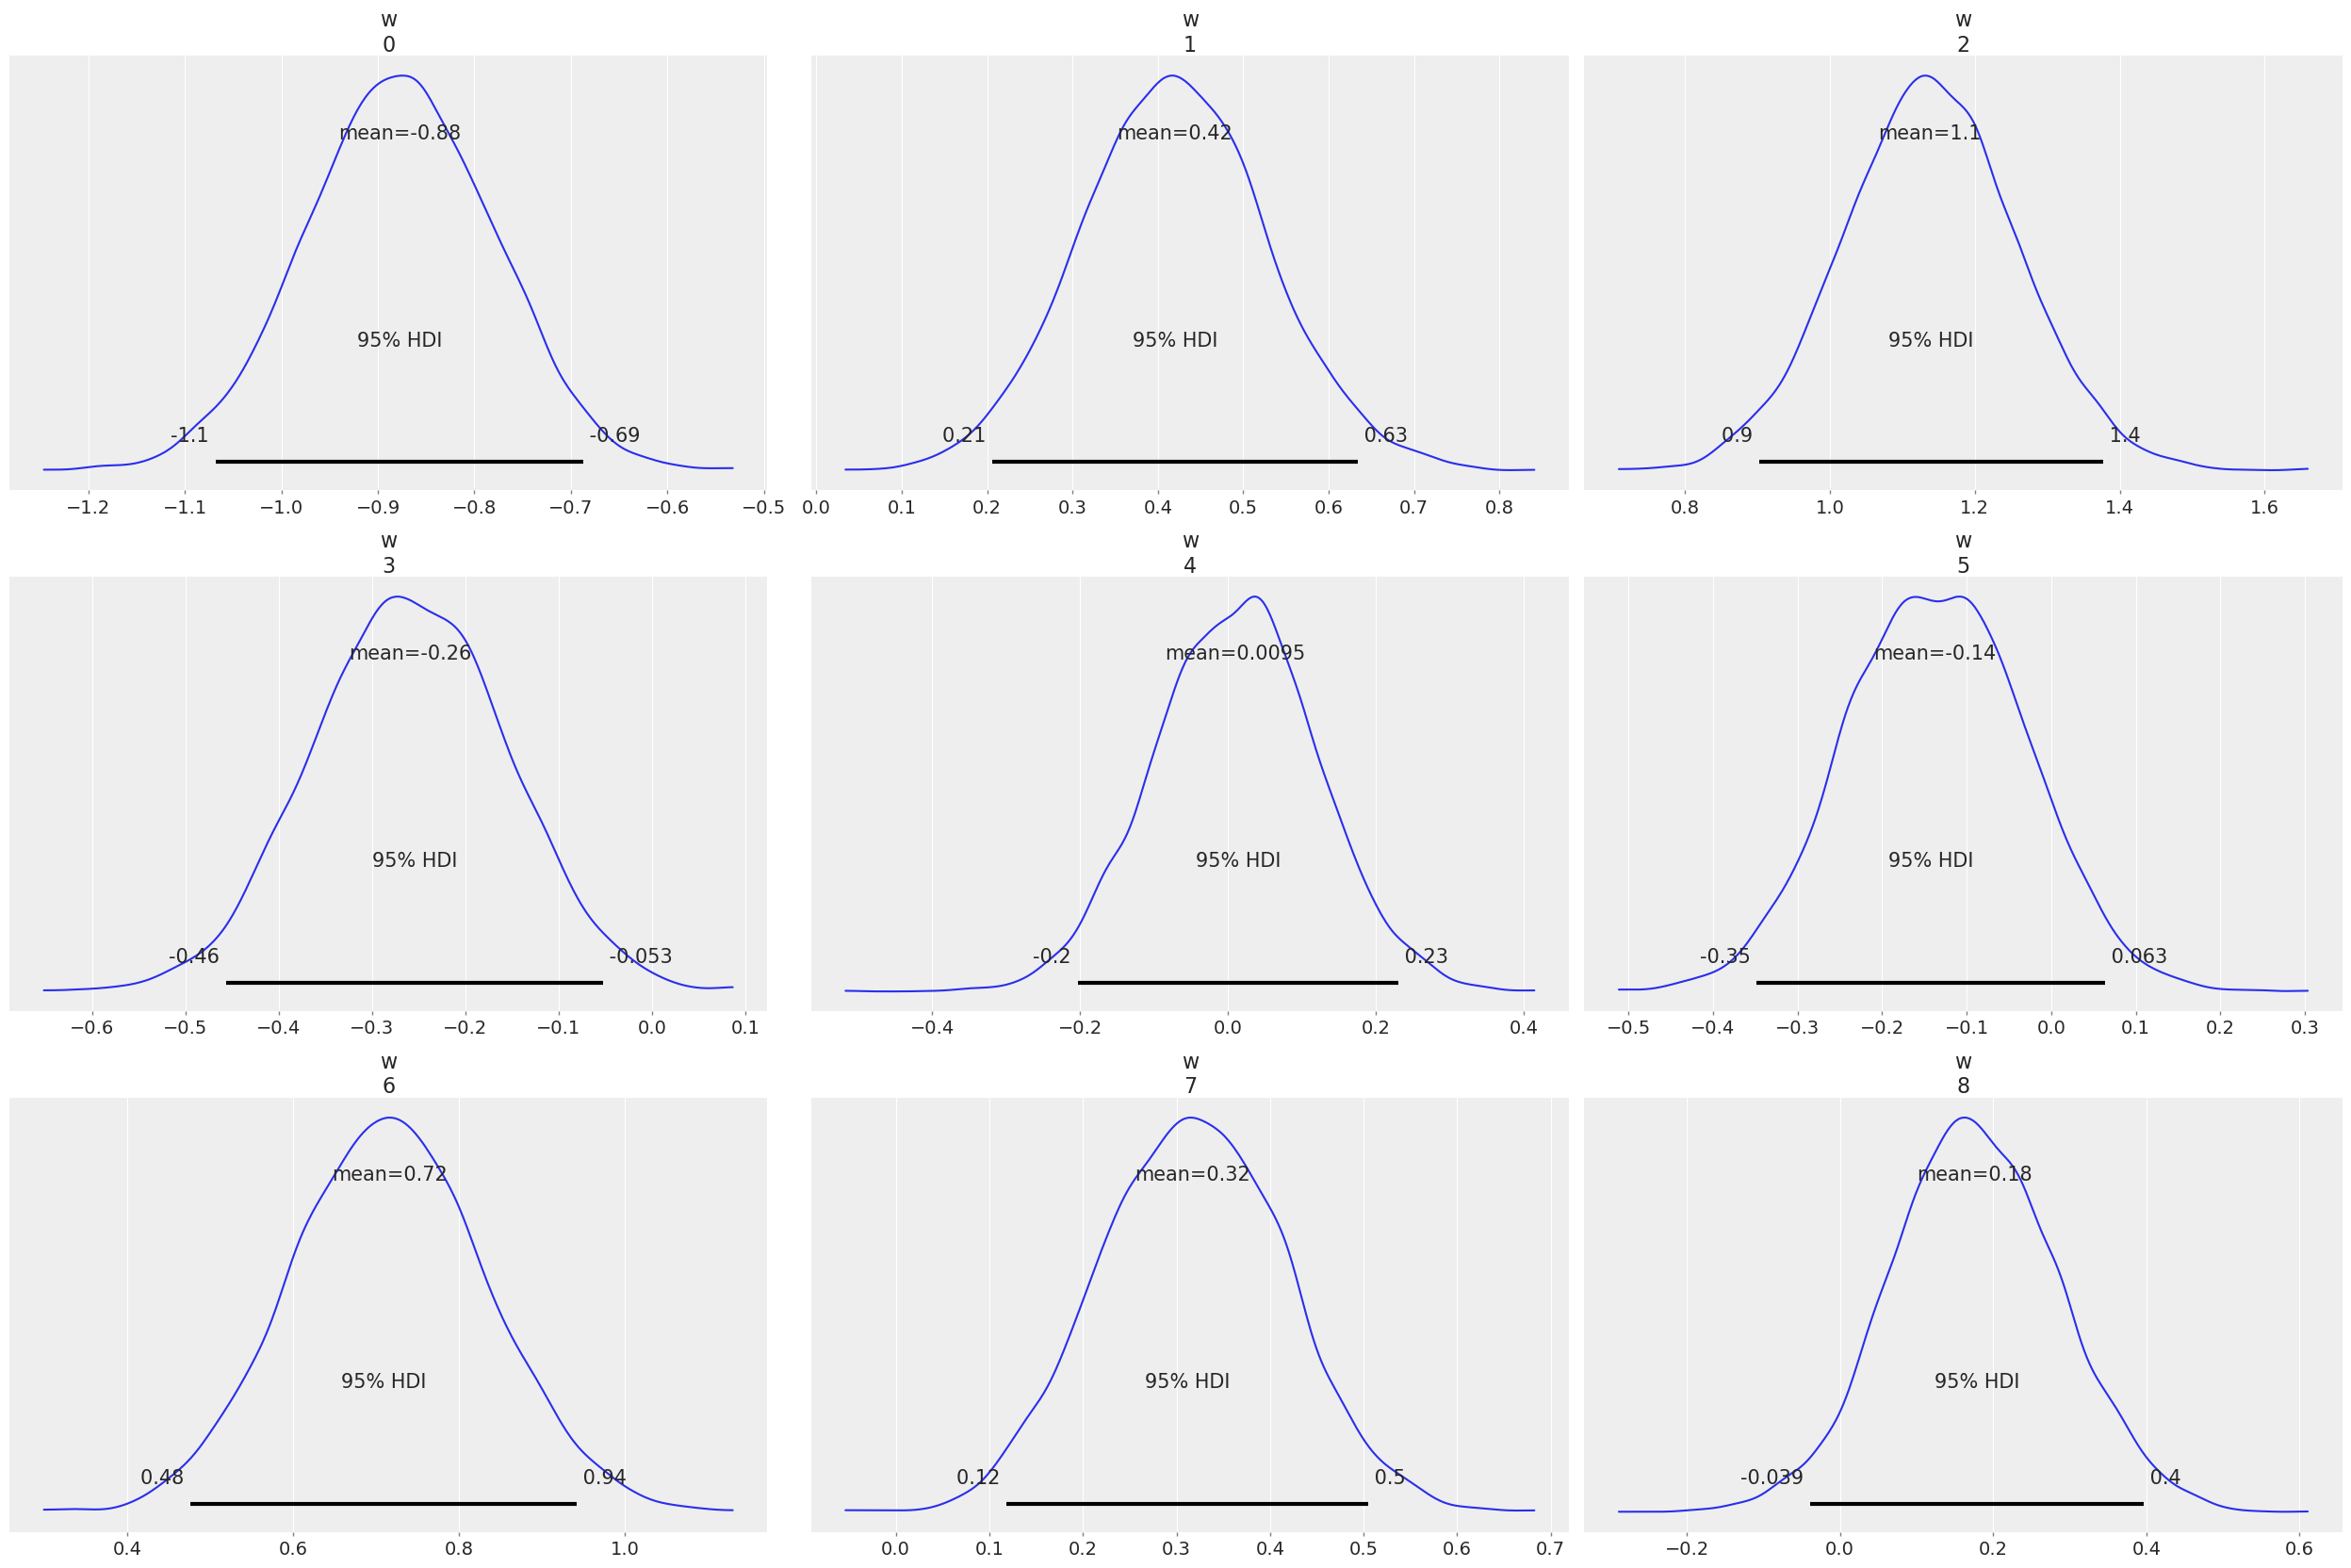

In [74]:
az.plot_posterior(trace, hdi_prob=0.95)
plt.show()

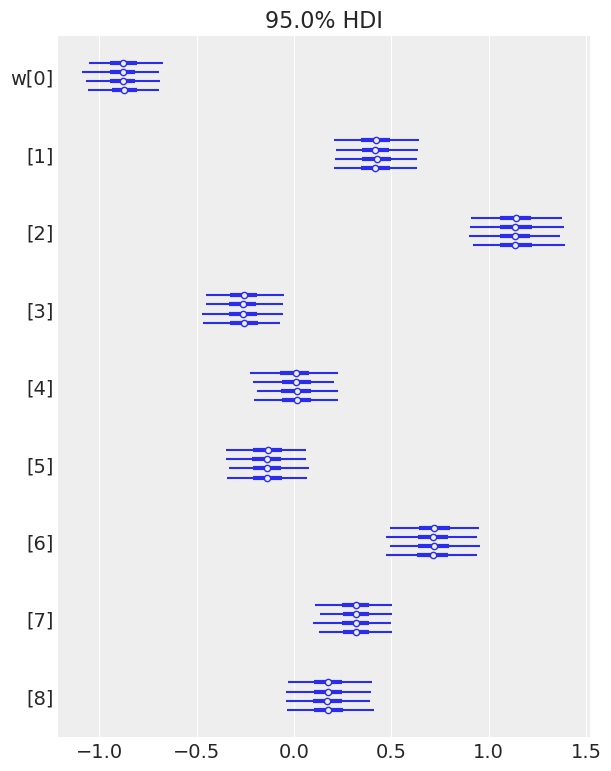

In [325]:
az.plot_forest(trace, hdi_prob=0.95)
plt.show()

So we have weights samples for normalized data. Now we will calculate the weights for original data.

$\mathbf x^o ~-$ normalized data, $\mathbf w ~-$ weights for normalized data; 
$\mathbf x ~-$ original data, $w ~-$ weigths for original data.

$$\theta(x) = \mathrm{logit}(\mathbf w^T \mathbf x^o)
\\
\mathbf w^T \mathbf x^o = \mathbf w_0 + \sum\limits_{i=1}^n \mathbf w_i x_i^{o} = \mathbf w_0 + \mathbf w_1 \frac{\mathbf x_1 - m_1}{\sigma_1} + \ldots + \frac{\mathbf x_n - m_n}{\sigma_n} = \mathbf w_0 - \sum\limits_{i=1}^n \mathbf w_i \frac{m_i}{\sigma_i} + \frac{\mathbf w_1}{\sigma_1} \mathbf x_1 + \ldots + \frac{\mathbf w_n}{\sigma_n} \mathbf x_n = w_0 + \sum\limits_{i=1}^n w_i \mathbf x_i = w^T \mathbf x
$$

where $w_0=\mathbf w_0 - \sum\limits_{i=1}^n \mathbf w_i \frac{m_i}{\sigma_i}$; $w_i=\frac{\mathbf w_i}{\sigma_i},\ i=\overline{1,n}$.

In [298]:
w_posterior = np.stack([trace.posterior['w'][...,i].values.reshape(-1) for i in range(trace.posterior['w'].shape[-1])]).T
w_posterior.shape

(8000, 9)

In [303]:
def recalc_weights(w, m, sig):
    weights = w.copy()
    weights[:,0] -= np.sum([weights[:,i]*m[i-1]/sig[i-1] for i in range(1,weights.shape[1])], axis = 0)
    for i in range(1,weights.shape[1]):
        weights[:,i] /= sig[i-1]
    return weights
w_sample = recalc_weights(w_posterior, means, scales)

Now we will calculate predicted probabilities for all $768$ objects in dataset. At first, we fit all $8000$ models to every object. Therefore, we have $8000$ probabilities for every object. To get only one predicted probability for every object we will average the bunch of predictions obtained by the ensemble of $8000$ models.

In [287]:
predictors = np.hstack([np.ones(shape=(reg.shape[0], 1)), reg])
all_probs = logistic.cdf(w_sample @ predictors.T)
probs = np.mean(all_predicts, axis = 0)
[probs[:5], np.array(t)[:5]]

[array([0.72134513, 0.04835125, 0.79437775, 0.04139767, 0.89265929]),
 array([1, 0, 1, 0, 1], dtype=int64)]

Let's evaluate the adequacy of the model on the training data. To do this, we fix a trivial cutoff level $0.5$. So $\{t=1\}  \Longleftrightarrow \{\theta(x) > 0.5\}$.

In [283]:
cutoff = 0.5
predicts = list(map(int, probs > cutoff))
np.sum(predicts == np.array(t))/predictors.shape[0]

0.7825520833333334

Accuracy $78.26\%$ is acceptable.

## Prediction of new data

Now let's turn to the Internet to find out the indicators of a healthy and diabetic person.
- `Pregnancies`: Equals $2$ for both patients;
- `Glucose`: A blood sugar level less than $140$ mg/dL ($7.8$ mmol/L) is normal. A reading of more than $200$ mg/dL ($11.1$ mmol/L) after two hours indicates diabetes. A reading between $140$ and $199$ mg/dL ($7.8$ mmol/L and $11.0$ mmol/L) indicates prediabetes;
    + Healthy patient's level is $135$ - normal;
    + Sick patient's level is $185$ - prediabetic;
- `BloodPressure`: Blood pressure should be below $140/80$mmHg for people with diabetes;
    + Healthy patient's pressure is $85$;
    + Sick patient's pressure is $65$;
- `SkinThickness`: normal - $20.6$, Type 1 diabetes - $8.9~–36.8$;
    + Healthy patient's thickness is $20.6$;
    + Sick patient's thickness is $10$;
- `Insulin`: Equals $90$ for both patients;
- `BMI`: A higher risk of diabetes was observed at a BMI of $23 kg/m^2$ or higher;
    + Healthy patient's BMI is $21.7$;
    + Sick patient's BMI is $30$;
- `DiabetesPedigreeFunction`: A function which scores likelihood of diabetes based on family history;
    + Healthy patient's value is $0.3$;
    + Sick patient's value is $0.7$;
- `Age`: Equals $35$ for both patients.

In [329]:
x_healthy = [1, 2, 135, 85, 20.6, 90, 21.7, 0.3, 35]
x_sick    = [1, 2, 185, 65, 10,   90, 30,   0.7, 35]
def hist_prob(x, w_sample):
    p = logistic.cdf(w_sample @ x)
    plt.hist(p, density=True, alpha=0.3)
    kde = stats.gaussian_kde(p)
    x_grid = np.linspace(0, 1, 1000)
    plt.plot(x_grid, kde(x_grid))

Let $\theta(\mathbf x)$ be a probability of diabetes for patient $\mathbf x$.

Distribution of $\theta$ for healthy patient.

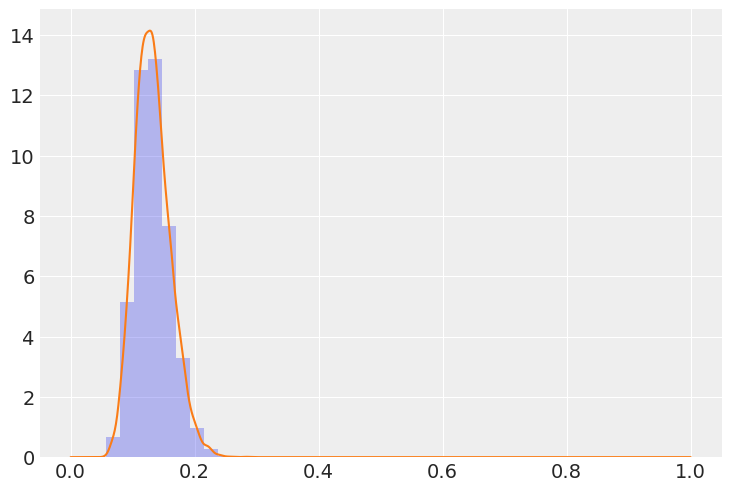

In [330]:
hist_prob(x_healthy, w_sample)

Distribution of $\theta$ for diabetic patient.

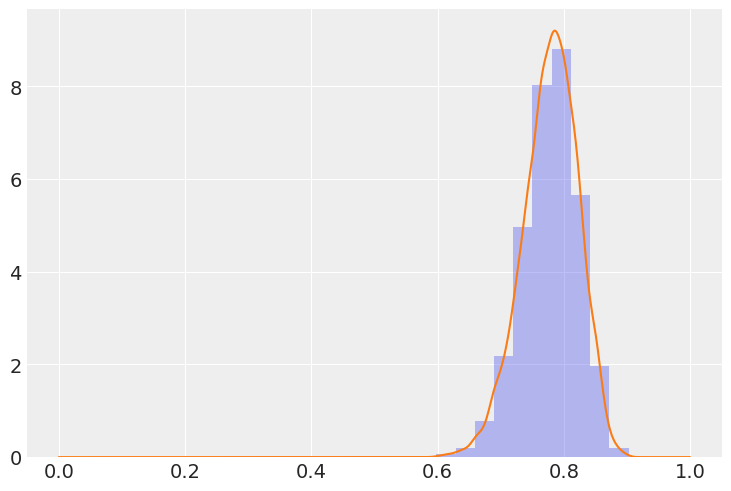

In [331]:
hist_prob(x_sick, w_sample)